# How to Predict Dog Breed with Transfer Learning

## Introduction

Earlier, in my ["WeRateDogs Data Wrangling" project](https://github.com/carterjin/Twitter-WeRateDogs-Data-Wrangling), we used some results provided by Udacity which take dog pictures and predicts its dog breeds. Now I would like to implement this myself.

This Project also serves as my Capstone Project for Udacity Data Scientist Nanodegree. The training/validation/test data and bottleneck features data has already been given by Udacity, but I actually did it from scratch and want to show you how to do that. For example if you have only png files and labels, how would you do this.

The data is downloaded from [Dog Breed Identification Kaggle Competition](https://www.kaggle.com/c/dog-breed-identification/data). The original data is from [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). The data contains 10222 dog photos and labels indicating the breed, a total 120 different breeds.

Alternatively, in order to have this notebook run in Udacity, I am also including the data and methods I used for the Udacity Project: [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip), and differentiate which one to run by a variable: data_flag.

The data for human recognition is also provided by Udacity: [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)

### package requirements
- keras 2.1.6
- tensorflow 1.14.0
- sklearn 0.19.1
- numpy
- pandas
- matplotlib
- openCV
- PIL

### What to Expect:
* [1. Read Dog Dataset](#1)
* [2. Create a CNN to Classify Dog Breeds from Scratch](#2)
* [3. Create a CNN to Classify Dog Breeds (using Transfer Learning)](#3)
* [4. Detect Humans and Dogs](#4)
* [5. Wrap up and the Final Algorithm](#5)


In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,\
GlobalAveragePooling2D
from keras import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras

from sklearn.model_selection import train_test_split

from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you are running with kaggle data, change this to Kaggle
data_flag = 'Udacity'

Using TensorFlow backend.


---
<a id='1'></a>
## 1. Read Dog Dataset

### Kaggle Dataset

Download the train folder and labels.csv file and put them in the same directory as this notebook.

In [2]:
if data_flag == 'Kaggle':
    labels = pd.read_csv('labels.csv')

In [3]:
if data_flag == 'Kaggle':
    data_dir = ''
    def read_img(img_id, train_or_test, size):
        '''
        Img_id: a string that is also the file name of the picture in train/test folder
        train_or_test: a string indicating if the file is in train or test folder
        size: a tuple ie (224,224) indicating the target size of the converted matrix
        returns:
        img: a matrix with shape depending on size, ie (224, 224, 3)
        '''
        img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
        img = image.img_to_array(img)
        return img

ResNet50 is a popular deep residual learning framework for image classification. ImageNet is a set of pretrained weights that we can later use transfer training on. Let's first see how good is the prediction using ImageNet without any training. Considering time, I am only testing the first 20 samples.

In [4]:
if data_flag == 'Kaggle':
    model = ResNet50(weights = 'imagenet')
    success = 0
    fail = 0
    i = 0
    for (img_id, breed) in labels.values:
        img = read_img(img_id, 'train', (224,224))
        x = preprocess_input(np.expand_dims(img.copy(), axis = 0))
        preds = model.predict(x)
        top_pred = decode_predictions(preds, top = 1)[0][0][1]
        if (top_pred == breed):
            success += 1
        else:
            fail += 1
        i += 1
        if i % 10 == 0: print(i, ' finished')
        if i == 20: break
    print(success/(success + fail))

Interestingly, without any training, we already got 35% accuracy to predict the breed. This serves as a baseline for our performance. Later in [Part 5](#5), we also use this same CNN to predict whether a picture is dog to almost 100% accuracy.

I am reading all the image into a matrix X, which has shape 

$$
(\text{num of training sample}, 224, 224, 3).
$$

Also preprocess_input converts the values to be 0 centered, and converted from RGB coding to BGR coding, which the ImageNet weights used. img is expanded from $(224,224,3)$ to $(1,224,224,3)$ to fit in matrix X.

In [5]:
if data_flag == 'Kaggle':
    from time import time
    bef = time()
    X = np.zeros((len(labels),224,224,3), dtype = 'float32')
    for i, img_id in enumerate(labels.id):
        img = read_img(img_id, 'train', (224,224))
        x = preprocess_input(np.expand_dims(img, axis = 0))
        X[i] = x
    print(int(time() - bef),' second spent')
    # Get dummy variables for the breed
    y = pd.get_dummies(labels.breed)
    dog_names = y.columns

In [6]:
if data_flag == 'Kaggle':
    X.shape

In [7]:
if data_flag == 'Kaggle':
    num_classes = y.shape[1]

In [8]:
if data_flag == 'Kaggle':
    X, X_test, y, y_test = train_test_split(
        X, y, test_size=0.1)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.125)

### Udacity Dataset
For the Project with Udacity I am using the provided code to read dataset as follows, there is just some minor difference such as number of samples and number of breeds etc. Eventually the data is also loaded to X_train, y_train, etc.

In [9]:
if data_flag == 'Udacity':
    from sklearn.datasets import load_files       
    from keras.utils import np_utils
    import numpy as np
    from glob import glob

    # define function to load train, test, and validation datasets
    def load_dataset(path):
        data = load_files(path)
        dog_files = np.array(data['filenames'])
        dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
        return dog_files, dog_targets

    # load train, test, and validation datasets
    train_files, train_targets = load_dataset('../../../data/dog_images/train')
    valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
    test_files, test_targets = load_dataset('../../../data/dog_images/test')

    # load list of dog names
    dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

    # print statistics about the dataset
    print('There are %d total dog categories.' % len(dog_names))
    print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
    print('There are %d training dog images.' % len(train_files))
    print('There are %d validation dog images.' % len(valid_files))
    print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
if data_flag == 'Udacity':
    from PIL import ImageFile                            
    ImageFile.LOAD_TRUNCATED_IMAGES = True   
    X_train = preprocess_input(paths_to_tensor(train_files))
    X_val = preprocess_input(paths_to_tensor(valid_files))
    X_test = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 836/836 [00:06<00:00, 139.13it/s]


In [12]:
if data_flag == 'Udacity':
    y_train = train_targets
    y_val = valid_targets
    y_test = test_targets

In [13]:
num_classes = y_train.shape[1]
print('Number of dog breeds is: ',num_classes)

Number of dog breeds is:  133



---
<a id='2'></a>
## 2. Create a CNN to Classify Dog Breeds from Scratch

In this step, I am building a CNN model from scratch. 
I need to mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="200"> 

I'd also like to mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Model Architecture
This CNN architecture is pretty balanced in the number of layers so the training time wouldn't be too long, it would be near impossible if for example we want to take a VGG or ResNet network and train all the parameters.

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential([
    Conv2D(input_shape = (224,224,3), filters = 16, kernel_size = 2),
    MaxPooling2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2),
    MaxPooling2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2),
    MaxPooling2D(pool_size = 2),
    GlobalAveragePooling2D(input_shape = (27,27,64)),
    Dense(133, activation = 'softmax')]
)

model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
______

__Warning:__ The following code takes about 10 minutes to run:

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint  

epochs = 5
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 129s 19ms/step - loss: 6.0761 - acc: 0.0120 - val_loss: 5.1869 - val_acc: 0.0096

Epoch 00001: val_loss improved from inf to 5.18688, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/5
6680/6680 [==============================] - 131s 20ms/step - loss: 5.3608 - acc: 0.0156 - val_loss: 5.3647 - val_acc: 0.0048

Epoch 00002: val_loss did not improve from 5.18688
Epoch 3/5
6680/6680 [==============================] - 131s 20ms/step - loss: 5.3582 - acc: 0.0139 - val_loss: 5.2453 - val_acc: 0.0228

Epoch 00003: val_loss did not improve from 5.18688
Epoch 4/5
6680/6680 [==============================] - 131s 20ms/step - loss: 5.4835 - acc: 0.0132 - val_loss: 5.6445 - val_acc: 0.0072

Epoch 00004: val_loss did not improve from 5.18688
Epoch 5/5
6680/6680 [======================

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [17]:
def test_accuracy(model, X_test, y_test, stop_early = None):
    X_test = X_test[:stop_early]
    y_test = y_test[:stop_early]
    dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)

In [18]:
test_accuracy(model, X_test, y_test)

Test accuracy: 1.9139%


This is just a little better than 1%, not too much better than guessing.

---
<a id = '3'></a> 
## 3. Create a CNN to Classify Dog Breeds (using Transfer Learning)
### 3.1 Pre-trained Model as Feature Extractor in Model
This method uses this as reference:

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

I also took advantage of data augmentation. However, to warn you first, it is very slow, and may run hours and hours. So if you are not interested, just jump to [3.2 Train using bottleneck features](#3_2).

### Feature Extraction Layers
I am importing the pretrained Imagenet weight ResNet50 model without the classifier layers on the top, freeze this base model so it's not trainable, and then manually add the trainable classifier.

In [19]:
base_model = ResNet50(input_shape = (224,224,3),
                      include_top = False,
                      weights = 'imagenet')
base_model.trainable = False
base_model.summary()



94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________

### Add the classifier layers

In [20]:
global_average_layer = GlobalAveragePooling2D(input_shape = base_model.output_shape[1:])
drop_layer = Dropout(0.5)
prediction_layer = Dense(num_classes, activation = 'softmax')

In [21]:
model = Sequential([base_model, 
                    #global_average_layer, #Add this layer if you use keras > 2.2.0
                    drop_layer, 
                    prediction_layer])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 133)         272517    
Total params: 23,860,229
Trainable params: 272,517
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile the model


In [23]:
learning_rate = 0.003
model.compile(optimizer = RMSprop(lr = learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

The size of the data is barely handled with my memory and takes a long time, so I am saving all the train, test, validation data in a file.

In [20]:
#import joblib
#file = 'X_all'
#joblib.dump([X_train,y_train, X_val, y_val, X_test, y_test], file)

In [ ]:
#import joblib
#[X_train, y_train, X_val, y_val, X_test, y_test] = joblib.load('X_all')

I am using a data generator which also augments the data with rotation, shift, zoom, etc.

In [27]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator = datagen.flow(x = X_train, y = y_train)
val_generator = datagen.flow(x = X_val, y = y_val)
test_generator = datagen.flow(x = X_test, y = y_test)

__Warning:__ This following code takes about 30 minutes to run one epoch, thus really takes overnight to run 12 epochs. So really although I have tried running overnight for a few times, but I don't suggest you to run this.

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath = 'saved_model/best_val.hdf5')
history = model.fit_generator(train_generator, validation_data = val_generator, epochs = 12, callbacks = [checkpointer],
                             verbose = 1)

I am saving the result after an overnight run:

In [ ]:
!mkdir saved_model
model.save('saved_model/my_model')

In [ ]:
model = keras.models.load_model('saved_model/my_model')

In [ ]:
test_accuracy(model, X_test, y_test,30)

For the Kaggle dataset, I got 80% accuracy.

In [24]:
def decode(pred, classes, top = 3):
    # decode the prediction vector into a list of tuples consisting class name and probabilities, default top 3 is given
    result = [('',0.0)] * len(classes)
    for idx,prob in enumerate(pred[0]):
        result[idx] = classes[idx], prob
    result.sort(key = lambda x: x[1], reverse = True)
    return result[:top]

<a id = '3_2'></a>
### 3.2 Train using bottleneck features

One of the problem with the previous method is that when training, X_train needs to go through the ResNet base model (without classifier layers), and that makes the whole process taking around 10 hours to run on my laptop. While in fact, the base model parameters can't even be trained, so we can just train on the features we obtain from ResNet base models, which are called bottleneck features. This drastically decrease the computation time. However, the down side is we can't take advantage of image augmentation anymore.

A side note: The output shape of a topless ResNet50 netowork has been changed to 1,1,2048 to 7,7,2048 in keras version 2.2.0. Udacity bottleneck data uses the old definition, so I also downgraded keras to be consistent. But other than this part whether to use the new or old version doesn't matter.

We first run the train data through the base model to get the bottleneck features:

__Warning:__ The following code takes about 20 minutes to run:

In [25]:
bottleneck_features_train = base_model.predict(X_train, verbose = 1)
bottleneck_features_val = base_model.predict(X_val, verbose = 1)
bottleneck_features_test = base_model.predict(X_test, verbose = 1)

836/836 [==============================] - 131s 157ms/step


Again this takes a while, so you may want to save it, but still better than overnight run.

In [ ]:
import joblib
file = 'bottleneck_feature'
joblib.dump([bottleneck_features_train,y_train, bottleneck_features_val, y_val],
            file)

Also note that for different CNN models you need different preprocessing functinos, so you need to import preprocess input from the correct source and reload all the train/val/test data. i.e. if you are using InceptionV3 model you need:
```
from keras.applications.inception_v3 import InceptionV3, preprocess_input
```
For Udacity the bottleneck features are already given, so we can go ahead and load it.
- [VGG-16](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz) bottleneck features
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG16`, `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one or all of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

In [26]:
if data_flag == 'Udacity':
    # change the model choice to test out different models
    model_choice = 'Resnet50'
    bottleneck_features = np.load('bottleneck_features/Dog'+model_choice+'Data.npz')
    bottleneck_features_train = bottleneck_features['train']
    bottleneck_features_val = bottleneck_features['valid']
    bottleneck_features_test = bottleneck_features['test']

In [27]:
if data_flag == 'Kaggle':
    model_choice = 'Mymodel'
model = Sequential(
    [GlobalAveragePooling2D(input_shape = bottleneck_features_train.shape[1:]),
    Dense(256, activation = 'relu'),
    Dropout(0.6),
    Dense(num_classes, activation = 'softmax')]
)
learning_rate= 0.001
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.'+model_choice+'.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(bottleneck_features_train, y_train, 
          validation_data=(bottleneck_features_val, y_val),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 556us/step - loss: 3.5512 - acc: 0.2114 - val_loss: 1.4454 - val_acc: 0.6503

Epoch 00001: val_loss improved from inf to 1.44535, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 319us/step - loss: 1.9005 - acc: 0.4768 - val_loss: 0.9332 - val_acc: 0.7413

Epoch 00002: val_loss improved from 1.44535 to 0.93323, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 322us/step - loss: 1.4254 - acc: 0.5843 - val_loss: 0.7920 - val_acc: 0.7665

Epoch 00003: val_loss improved from 0.93323 to 0.79203, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 4/20
6680/6680 [==============================] - 2s 325us/step - loss: 1.2053 - acc: 0.6334 - val_loss: 0.7094 - val_acc: 0.7772

Epoch 00004: val_loss improved from 0.79203 to 0.70942, saving model to s

Indeed, earlier it took about 30 minute to run each epoch, now it took only a few seconds.

In [29]:
model.load_weights('saved_models/weights.best.'+model_choice+'.hdf5')
test_accuracy(model, bottleneck_features_test, y_test)

Test accuracy: 81.1005%


By changing ```model_choice``` I tried out VGG16, ResNet50, InceptionV3. The follow are the accuracy on test data for all three models.
__Accuracy test:__
- VGG16: 72.13%
- ResNet50: 81.46%
- InceptionV3: 80.98%

I have confirmed that using the bottleneck features I calculated vs the bottleneck features that is provided by Udacity gives the same result.

Let's write a function to predict the dog breed by giving the image path.

In [30]:
def ResNet50_predict_breed(img_path):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    tensor = path_to_tensor(img_path)
    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
ResNet50_predict_breed('test_images/test1.jpg')

'ages/train/006.American_eskimo_dog'

<a id='4'></a>
## 4. Detect Humans and Dogs

### 4.1 Detect Humans

I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

### Import Dataset

In [31]:
import random
random.seed(42)
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

Number of faces detected: 1


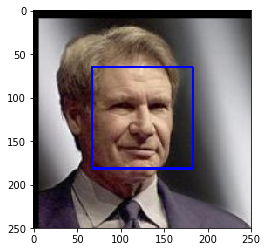

In [32]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector
Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [33]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [34]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

h_percentage = np.fromiter((face_detector(h) for h in human_files_short), bool).mean()
print('Percentage of human files detected human face: %.2f%%' % (h_percentage*100))
d_percentage = np.fromiter((face_detector(d) for d in dog_files_short), bool).mean()
print('Percentage of dog files detected human face: %.2f%%' % (d_percentage*100))

Percentage of human files detected human face: 99.00%
Percentage of dog files detected human face: 11.00%


### 4.2 Detect Dogs

We have already seen how to use transfer learning with ResNet-50 to identify dog breeds. However, we can also use the complete ResNet-50 model along with weights that have been trained on [ImageNet](http://www.image-net.org/) to directly identify the object. Given an image, this pretrained ResNet-50 model will return a prediction for the object contained in the image.

In [35]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    from keras.applications.resnet50 import preprocess_input
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

102858752/102853048 [==============================] - 1s 0us/step


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [37]:
def is_dog_files(files):
    '''
    Input: a list of files with images
    Output: an numpy array of bool values of the prediction whether the picture is a dog
    '''
    X = paths_to_tensor(files)
    X = preprocess_input(X)
    preds = np.argmax(ResNet50_model.predict(X), axis = 1)
    is_dog = np.array((preds <= 268) & (preds >= 151))
    return is_dog

print('Percentage of human files detected dog: %.2f%%' % (is_dog_files(human_files_short).mean() * 100))
print('Percentage of dog files detected dog: %.2f%%' % (is_dog_files(dog_files_short).mean()*100))

 22%|██▏       | 22/100 [00:00<00:00, 211.11it/s]

Percentage of human files detected dog: 4.00%


100%|██████████| 100/100 [00:00<00:00, 142.77it/s]


Percentage of dog files detected dog: 100.00%


As a conclusion, we can see that both human and dog detector detects 100% it intended targets, but the chance of a dog detector mistakenly detects a human is much less likely than a human detector mistakenly detects a dog.

<a id='5'></a>
## 5. Wrap up and the Final Algorithm

In this part I will write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

Because the dog detector is less likely to mistake a man for a dog, we use it first. If it failed to identify the object as a dog, then we try to see if we can identify it as a human. If both fail, we determine that it is neither. If either pass, we run the picture by the algorithm in part 3 and see what breed it predicts.

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_img(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return None

def predict_breed(img_path):
    # print image
    display_img(img_path)
    # test if the picture is a human
    if dog_detector(img_path):
        print('Hi, dog!\n Your breed is:')
    elif face_detector(img_path):
        print('Hi, human!\n If you were a dog, your breed would be:')
    else:
        print('You are neither a human or a dog')
        return None
    breed = ResNet50_predict_breed(img_path)
    print(breed.split('.')[1])
    return breed

### Testing the Algorithm

Let's see what the algorithm say about some dog pictures and just random pictures I found online:

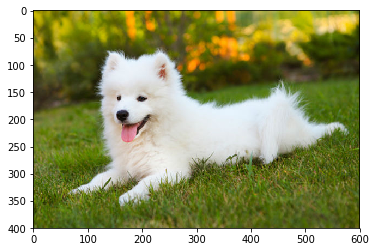

Hi, dog!
 Your breed is:
American_eskimo_dog





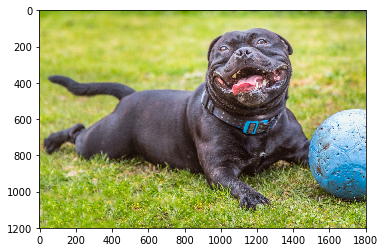

Hi, dog!
 Your breed is:
Cane_corso





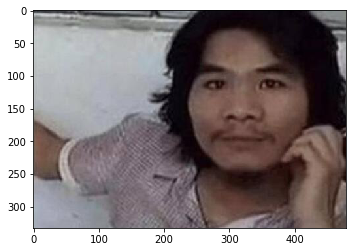

Hi, human!
 If you were a dog, your breed would be:
French_bulldog





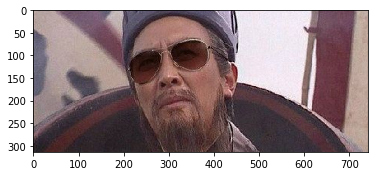

Hi, human!
 If you were a dog, your breed would be:
Chinese_crested





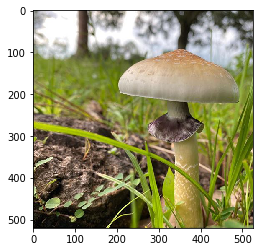

You are neither a human or a dog





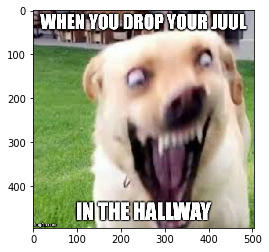

Hi, dog!
 Your breed is:
Labrador_retriever





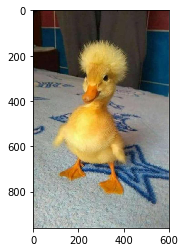

You are neither a human or a dog





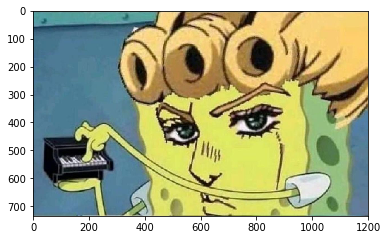

You are neither a human or a dog





In [39]:
images = ['test1.jpg','test2.jpg','test3.jpeg','test4.jpg','test5.jpg','test6.jpg','test7.jpg','test8.jpg']
for im in images:
    predict_breed('test_images/'+ im)
    print('\n\n')

The result is pretty good for this set of pictures!